2024-11-23 23:32:37,222 - INFO - 数据文件 user_login_data.csv 已存在，直接加载
2024-11-23 23:32:37,229 - INFO - 训练数据加载完成
/tmp/ipykernel_1096353/2539609766.py:196: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_stats["平均登录间隔"].fillna(0, inplace=True)
2024-11-23 23:32:37,264 - INFO - 数据预处理完成
2024-11-23 23:32:37,333 - INFO - 异常检测模型构建完成
2024-11-23 23:32:37,333 - INFO - 规则已添加: 频繁登录失败 - 用户在短时间内多次失败尝试登录
2024-11-23 23:32:37,333 - INFO - 规则已添加: 同账号多地址登录 - 同一账号在一小时内从多个不同源地址登录
2024-11-23 23:32:37,334 - INFO - 规则已添加: 固定频率多账号尝试 - 在10分钟内有多个不同账号尝试登录

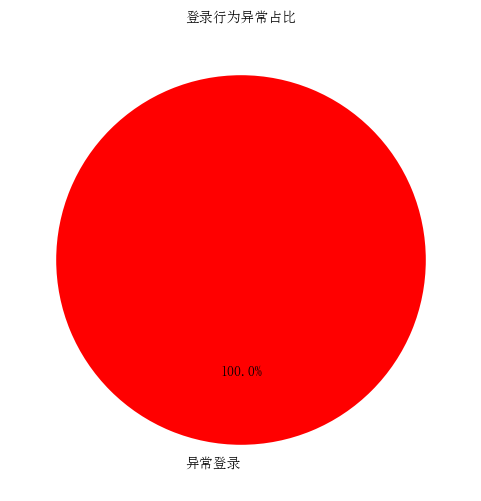

2024-11-23 23:32:37,578 - INFO - 模型已保存到 anomaly_detection_model.pkl
2024-11-23 23:32:37,621 - INFO - 检测结果已保存到 anomaly_detection_results.csv
2024-11-23 23:32:37,623 - INFO - 测试数据加载完成
/tmp/ipykernel_1096353/2539609766.py:196: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_stats["平均登录间隔"].fillna(0, inplace=True)
2024-11-23 23:32:37,634 - INFO - 数据预处理完成
2024-11-23 23:32:37,643 - INFO - 模型评估报告：
              precision    recall  f1-score   support

          正常       1.00      1.00      1.00         5
          异常       1.00   


检测到的异常登录记录：
           用户ID           登录地址   登录失败次数     登录成功率    平均登录间隔  \
0  unknown_user    192.168.1.5  3.46095 -4.102256 -1.973717   
1  unknown_user  198.51.100.27  3.46095 -4.102256 -1.973717   
2  unknown_user      10.0.0.20  3.46095 -4.102256 -1.973717   
3  unknown_user    172.16.0.40  3.46095 -4.102256 -1.973717   
4  unknown_user    172.16.0.44  3.46095 -4.102256 -1.973717   
5  unknown_user    172.16.0.41  3.46095 -4.102256 -1.973717   
6  unknown_user   203.0.113.36  3.46095 -4.102256 -1.973717   
7  unknown_user   192.168.1.41  3.46095 -4.102256 -1.973717   
8  unknown_user   192.168.1.41  3.46095 -4.102256 -1.973717   
9  unknown_user    192.168.1.8  3.46095 -4.102256 -1.973717   

                         异常类型  
0            同账号多地址登录, 未知用户尝试  
1  同账号多地址登录, 未知用户尝试, 非正常源地址登录  
2            同账号多地址登录, 未知用户尝试  
3            同账号多地址登录, 未知用户尝试  
4            同账号多地址登录, 未知用户尝试  
5            同账号多地址登录, 未知用户尝试  
6  同账号多地址登录, 未知用户尝试, 非正常源地址登录  
7            同账号多地址登录, 未知用户尝试  
8    

2024-11-23 23:32:46,778 - INFO - 最优参数：{'contamination': 0.1, 'max_samples': 0.8, 'n_estimators': 50}
2024-11-23 23:32:46,779 - INFO - 最佳模型得分：0.9901219512195121
2024-11-23 23:32:46,791 - INFO - 优化后的模型已保存到 optimized_anomaly_detection_model.pkl


[CV] END contamination=0.2, max_samples=1.0, n_estimators=200; total time=   0.1s
[CV] END contamination=0.2, max_samples=1.0, n_estimators=200; total time=   0.1s


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import ipaddress
import logging
import os
from matplotlib import font_manager as fm

# 设置中文字体（根据需要修改字体路径）
font_path = "simsun.ttc"  # 请确保字体文件在工作目录中
my_font = fm.FontProperties(fname=font_path)

# ------------------------------
# 设置日志
# ------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ------------------------------
# 工具函数
# ------------------------------
def ip_in_subnet(ip, subnets):
    """
    检查 IP 是否属于指定网段列表中的任何一个
    """
    try:
        ip_addr = ipaddress.ip_address(ip)
        for subnet in subnets:
            if ip_addr in ipaddress.ip_network(subnet):
                return True
        return False
    except ValueError:
        return False

# ------------------------------
# 异常规则模块
# ------------------------------
class AnomalyRules:
    def __init__(self):
        """
        初始化异常规则管理
        """
        self.rules = []

    def add_rule(self, name, func, description=""):
        """
        添加新的异常规则
        """
        if not callable(func):
            raise ValueError(f"规则 {name} 的逻辑必须是一个可调用对象（函数）。")
        self.rules.append({"name": name, "func": func, "description": description})
        logging.info(f"规则已添加: {name} - {description}")

    def apply_rules(self, df):
        """
        应用所有规则并生成 '规则异常' 标记
        """
        results = {}
        for rule in self.rules:
            logging.info(f"正在应用规则: {rule['name']} ({rule['description']})")
            results[rule["name"]] = rule["func"](df)

        # 合并规则结果
        anomaly_flags = pd.DataFrame(results)
        df["规则异常"] = anomaly_flags.any(axis=1).astype(int)
        df["异常类型"] = anomaly_flags.apply(
            lambda row: ", ".join([name for name, val in row.items() if val]), axis=1
        )

        # 统计每个规则匹配的数量
        for rule_name, matches in results.items():
            match_count = matches.sum()
            match_ratio = match_count / len(df)
            logging.info(f"规则 '{rule_name}' 匹配数量: {match_count} ({match_ratio:.2%})")

        logging.info("规则应用完成")
        return df

# ------------------------------
# 数据加载与生成
# ------------------------------
def generate_login_data(file_path="user_login_data.csv", num_records=10000):
    """
    生成模拟的用户登录数据并保存到指定文件
    """
    user_ids = [f"user{i}" for i in range(1, 201)]
    ip_addresses = ["192.168.1." + str(i) for i in range(1, 50)] + \
                   ["10.0.0." + str(i) for i in range(1, 50)] + \
                   ["172.16.0." + str(i) for i in range(1, 50)] + \
                   ["203.0.113." + str(i) for i in range(1, 50)]
    login_results = ["success", "failure"]

    data = {
        "用户ID": np.random.choice(user_ids, size=num_records),
        "登录时间": pd.date_range("2023-01-01", periods=num_records, freq="T"),
        "登录地址": np.random.choice(ip_addresses, size=num_records),
        "登录资源": np.random.choice(["server1", "server2", "server3"], size=num_records),
        "登录结果": np.random.choice(login_results, size=num_records, p=[0.8, 0.2]),
    }
    df = pd.DataFrame(data)

    # 添加已知的异常情况
    # 频繁登录失败
    for _ in range(50):
        user = np.random.choice(user_ids)
        failure_times = pd.date_range("2023-01-10", periods=5, freq="T")
        failure_data = {
            "用户ID": [user] * 5,
            "登录时间": failure_times,
            "登录地址": np.random.choice(ip_addresses, size=5),
            "登录资源": np.random.choice(["server1", "server2", "server3"], size=5),
            "登录结果": ["failure"] * 5,
        }
        df = pd.concat([df, pd.DataFrame(failure_data)], ignore_index=True)

    # 同账号多地址登录
    multi_ip_user = np.random.choice(user_ids)
    for _ in range(5):
        times = pd.date_range("2023-01-15", periods=5, freq="T")
        multi_ip_data = {
            "用户ID": [multi_ip_user] * 5,
            "登录时间": times,
            "登录地址": np.random.choice(ip_addresses, size=5, replace=False),
            "登录资源": np.random.choice(["server1", "server2", "server3"], size=5),
            "登录结果": np.random.choice(login_results, size=5, p=[0.8, 0.2]),
        }
        df = pd.concat([df, pd.DataFrame(multi_ip_data)], ignore_index=True)

    # 固定频率多账号尝试
    for _ in range(50):
        time = pd.Timestamp("2023-01-12 08:00:00")
        users = [f"unknown_user_{i}" for i in range(10)]
        fixed_freq_data = {
            "用户ID": users,
            "登录时间": [time] * 10,
            "登录地址": np.random.choice(ip_addresses, size=10),
            "登录资源": np.random.choice(["server1", "server2", "server3"], size=10),
            "登录结果": np.random.choice(login_results, size=10, p=[0.5, 0.5]),
        }
        df = pd.concat([df, pd.DataFrame(fixed_freq_data)], ignore_index=True)

    # 非正常源地址登录
    abnormal_ips = ["198.51.100." + str(i) for i in range(1, 51)]  # 修改为 1 到 50，长度为50
    abnormal_data = {
        "用户ID": np.random.choice(user_ids, size=50),
        "登录时间": pd.date_range("2023-01-20", periods=50, freq="T"),
        "登录地址": abnormal_ips,
        "登录资源": np.random.choice(["server1", "server2", "server3"], size=50),
        "登录结果": np.random.choice(login_results, size=50, p=[0.5, 0.5]),
    }
    df = pd.concat([df, pd.DataFrame(abnormal_data)], ignore_index=True)

    # 不存在的用户尝试
    unknown_user_data = {
        "用户ID": ["unknown_user"] * 50,
        "登录时间": pd.date_range("2023-01-25", periods=50, freq="T"),
        "登录地址": np.random.choice(ip_addresses + abnormal_ips, size=50),
        "登录资源": np.random.choice(["server1", "server2", "server3"], size=50),
        "登录结果": np.random.choice(login_results, size=50, p=[0.5, 0.5]),
    }
    df = pd.concat([df, pd.DataFrame(unknown_user_data)], ignore_index=True)

    df.to_csv(file_path, index=False, encoding="utf-8")
    logging.info(f"模拟登录数据生成并保存到 {file_path}")


# ------------------------------
# 数据预处理
# ------------------------------
def preprocess_data(df):
    """
    数据清洗和特征提取
    """
    df["登录时间"] = pd.to_datetime(df["登录时间"], errors="coerce")
   

    # 添加登录是否成功的标志
    df["登录成功"] = df["登录结果"].apply(lambda x: 1 if x == "success" else 0)

    # 计算每个用户的登录失败次数、成功次数和成功率
    user_stats = df.groupby("用户ID").agg(
        登录失败次数=("登录成功", lambda x: (x == 0).sum()),
        登录成功次数=("登录成功", lambda x: (x == 1).sum()),
        总登录次数=("登录成功", "count")
    ).reset_index()
    user_stats["登录成功率"] = user_stats["登录成功次数"] / user_stats["总登录次数"]


    # 计算每个用户的平均登录间隔
    df.sort_values(by=["用户ID", "登录时间"], inplace=True)
    df["时间差"] = df.groupby("用户ID")["登录时间"].diff().dt.total_seconds()
    avg_time_diff = df.groupby("用户ID")["时间差"].mean().reset_index(name="平均登录间隔")
    user_stats = user_stats.merge(avg_time_diff, on="用户ID", how="left")
    user_stats["平均登录间隔"].fillna(0, inplace=True)

    # 编码用户ID和地址
    encoder_user = LabelEncoder()
    user_stats["用户编码"] = encoder_user.fit_transform(user_stats["用户ID"])


         # 添加登录时间的小时特征
    df["登录小时"] = df["登录时间"].dt.hour
    # 添加每个用户的登录时间分布特征
    user_login_hours = df.groupby("用户ID")["登录小时"].nunique().reset_index(name="活跃小时数")
    user_stats = user_stats.merge(user_login_hours, on="用户ID", how="left")
    # 数据标准化
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    user_stats[["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]] = scaler.fit_transform(
        user_stats[["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]]
    )

    logging.info("数据预处理完成")
    return df, user_stats

# ------------------------------
# 异常登录检测模型构建
# ------------------------------
def build_detection_model(user_stats):
    """
    使用Isolation Forest构建异常检测模型
    """
    features = ["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]
    X = user_stats[features]

    # 训练Isolation Forest模型
    contamination_rate = 0.1  # 假设异常比例为10%
    model = IsolationForest(contamination=contamination_rate, random_state=42)
    model.fit(X)

    # 预测异常分数
    user_stats["模型异常分数"] = model.decision_function(X)
    user_stats["模型异常"] = model.predict(X)
    # -1表示异常，1表示正常

    logging.info("异常检测模型构建完成")
    return model, user_stats

# ------------------------------
# 规则检测异常行为
# ------------------------------
def apply_anomaly_rules(df):
    anomaly_rules = AnomalyRules()
    # 内部网段列表
    internal_subnets = ["192.168.0.0/16", "10.0.0.0/8", "172.16.0.0/12"]

    # 频繁登录失败
    anomaly_rules.add_rule(
        "频繁登录失败",
        lambda x: x.groupby("用户ID")["登录成功"].transform(
            lambda s: s.rolling(window=5, min_periods=5).sum() == 0
        ),
        "用户在短时间内多次失败尝试登录"
    )

    # 同账号多地址登录（阈值调整为>3）
    anomaly_rules.add_rule(
        "同账号多地址登录",
        lambda x: x.groupby(["用户ID", x["登录时间"].dt.floor('H')])["登录地址"].transform("nunique") > 3,
        "同一账号在一小时内从多个不同源地址登录"
    )

    # 固定频率多账号尝试（修改时间窗口为10分钟）
    anomaly_rules.add_rule(
        "固定频率多账号尝试",
        lambda x: x.groupby(x["登录时间"].dt.floor('10T'))["用户ID"].transform("nunique") > 5,
        "在10分钟内有多个不同账号尝试登录"
    )

    # 未知用户尝试（匹配所有以 unknown_user 开头的用户ID）
    anomaly_rules.add_rule(
        "未知用户尝试",
        lambda x: x["用户ID"].str.startswith("unknown_user"),
        "使用系统中不存在的用户尝试登录"
    )

    # 非正常源地址登录
    anomaly_rules.add_rule(
        "非正常源地址登录",
        lambda x: ~x["登录地址"].apply(lambda ip: ip_in_subnet(ip, internal_subnets)),
        "使用异常的源地址尝试登录"
    )

    df = anomaly_rules.apply_rules(df)
    return df



# ------------------------------
# 合并模型和规则的检测结果
# ------------------------------
def combine_anomaly_results(df, user_stats):
    """
    合并模型和规则的异常检测结果
    """
    # 合并必要的列，包括登录失败次数、登录成功率、平均登录间隔等
    df = df.merge(user_stats[["用户ID", "登录失败次数", "登录成功率", "平均登录间隔", "模型异常"]], on="用户ID", how="left")
    
    df["是否异常"] = df.apply(
        lambda row: 1 if row["模型异常"] == -1 or row["规则异常"] == 1 else 0, axis=1
    )
    logging.info("异常检测结果合并完成")
    return df

# ... 之后的代码保持不变


# ------------------------------
# 可视化异常数据
# ------------------------------
def visualize_anomalies(df):
    """
    绘制异常统计结果
    """
    anomaly_count = df["是否异常"].value_counts()
    labels = anomaly_count.index.map(lambda x: "异常登录" if x == 1 else "正常登录").tolist()

    plt.figure(figsize=(6, 6))
    plt.pie(
        anomaly_count,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=["red", "green"][:len(anomaly_count)],
        textprops={"fontproperties": my_font}  # 设置中文字体
    )
    plt.title("登录行为异常占比", fontproperties=my_font)
    plt.show()

    anomalies = df[df["是否异常"] == 1]
    print("\n检测到的异常登录记录：")
    print(anomalies[["用户ID", "登录地址", "登录失败次数", "登录成功率", "平均登录间隔", "异常类型"]].head(10))


def load_and_preprocess_test_data(test_file="user_login_test_data.csv"):
    """
    加载测试数据并进行预处理
    """
    if os.path.exists(test_file):
        test_df = pd.read_csv(test_file, encoding="utf-8")
        logging.info("测试数据加载完成")
        # 数据预处理
        test_df, test_user_stats = preprocess_data(test_df)
        return test_df, test_user_stats
    else:
        logging.warning(f"测试数据文件 {test_file} 不存在！")
        return None, None

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_user_stats):
    """
    使用测试数据评估模型
    """
    features = ["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]
    X_test = test_user_stats[features]

    # 使用模型进行预测
    test_user_stats["模型预测"] = model.predict(X_test)
    test_user_stats["模型异常"] = test_user_stats["模型预测"]  # 将模型预测结果映射为模型异常列

    # 计算准确率、召回率、F1等指标
    y_true = test_user_stats["模型异常"]
    y_pred = test_user_stats["模型预测"]

    # 输出分类报告
    report = classification_report(y_true, y_pred, target_names=["正常", "异常"])
    cm = confusion_matrix(y_true, y_pred)
    
    logging.info(f"模型评估报告：\n{report}")
    logging.info(f"混淆矩阵：\n{cm}")
    return report, cm


from sklearn.model_selection import GridSearchCV

def optimize_model(X_train, y_train, model):
    """
    使用网格搜索对模型进行优化
    """
    param_grid = {
        "contamination": [0.05, 0.1, 0.15, 0.2],  # 异常比例
        "n_estimators": [50, 100, 200],           # 决策树数量
        "max_samples": [0.8, 1.0]                  # 训练样本比例
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", verbose=2)
    grid_search.fit(X_train, y_train)

    # 输出最优参数
    logging.info(f"最优参数：{grid_search.best_params_}")
    logging.info(f"最佳模型得分：{grid_search.best_score_}")

    return grid_search.best_estimator_

# ------------------------------
# 主程序
# ------------------------------
if __name__ == "__main__":
    # 1. 数据生成
    data_file = "user_login_data.csv"
    if not os.path.exists(data_file):
        generate_login_data(file_path=data_file, num_records=10000)
    else:
        logging.info(f"数据文件 {data_file} 已存在，直接加载")

    # 2. 数据加载
    df = pd.read_csv(data_file, encoding="utf-8")
    logging.info("训练数据加载完成")

    # 3. 数据预处理
    df, user_stats = preprocess_data(df)

    # 4. 异常检测模型构建
    model, user_stats = build_detection_model(user_stats)

    # 5. 应用规则检测异常
    df = apply_anomaly_rules(df)

    # 6. 合并模型和规则的检测结果
    df = combine_anomaly_results(df, user_stats)

    visualize_anomalies(df)

    # 7. 保存模型和结果
    model_file = "anomaly_detection_model.pkl"
    import joblib
    joblib.dump(model, model_file)
    logging.info(f"模型已保存到 {model_file}")

    result_file = "anomaly_detection_results.csv"
    df.to_csv(result_file, index=False, encoding="utf-8")
    logging.info(f"检测结果已保存到 {result_file}")

    # 8. 加载并预处理测试数据
    test_file = "user_login_test_data.csv"
    test_df, test_user_stats = load_and_preprocess_test_data(test_file)

    if test_df is not None and test_user_stats is not None:

        # 使用训练好的模型对测试数据生成预测结果
        features = ["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]
        X_test = test_user_stats[features]
        test_user_stats["模型异常"] = model.predict(X_test)  # 使用模型生成预测结果
        
        # 9. 使用训练好的模型评估性能
        evaluate_model(model, test_user_stats)

        # 10. 优化模型（如果需要）
        features = ["登录失败次数", "登录成功率", "平均登录间隔", "活跃小时数"]
        X_train = user_stats[features]
        y_train = user_stats["模型异常"]
        
        optimized_model = optimize_model(X_train, y_train, model)

        # 保存优化后的模型
        optimized_model_file = "optimized_anomaly_detection_model.pkl"
        joblib.dump(optimized_model, optimized_model_file)
        logging.info(f"优化后的模型已保存到 {optimized_model_file}")

